# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  7.760784149169922
load_data: FFT of data, time:  9.215047836303711


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 64 x 64 

In [8]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


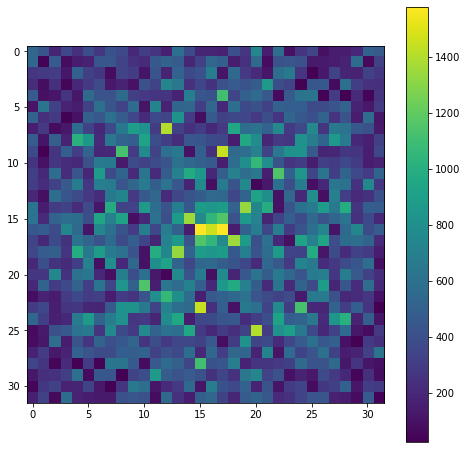

In [10]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

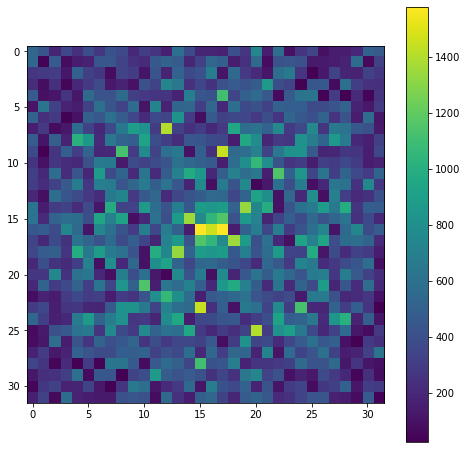

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

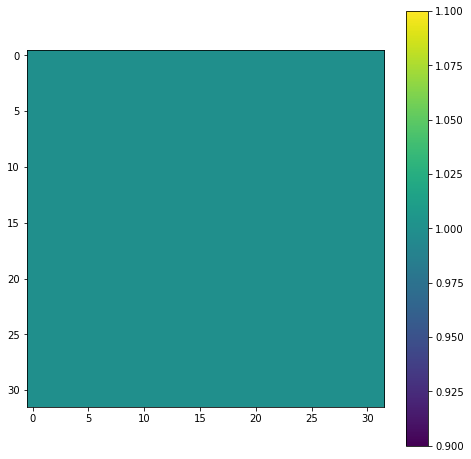

In [12]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [13]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

2.4720311164855957
(32, 32, 32)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

2.6497859954833984
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

  cg iter 0 ||r|| = 0.1594368352258542
  cg iter 50 ||r|| = 0.0017637171256580802


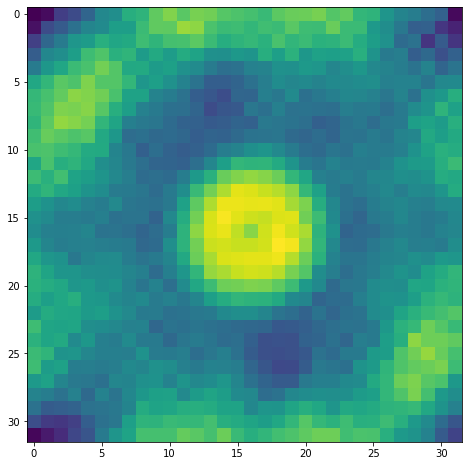

Iter  0
  Time orientations sampling = 6.280781269073486
  cg iter 0 ||r|| = 1.1138295043916644
  cg iter 50 ||r|| = 0.0009339629739676167
  Time cg = 8.46454119682312


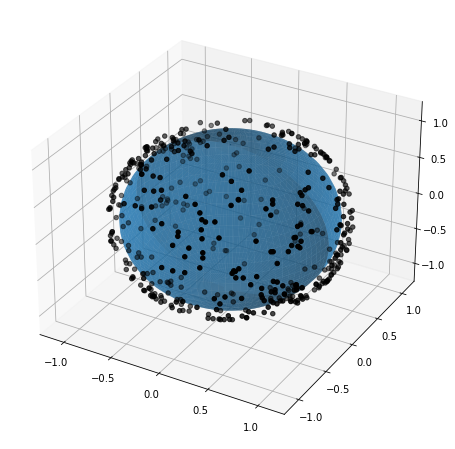

Iter  1
  Time orientations sampling = 2.738931179046631
  cg iter 0 ||r|| = 0.7630147584015974
  cg iter 50 ||r|| = 0.001767743647627704
  Time cg = 11.6498384475708
Iter  2
  Time orientations sampling = 2.452319622039795
  cg iter 0 ||r|| = 0.772040737841461
  cg iter 50 ||r|| = 0.0022044478691687825
  Time cg = 6.238473415374756
Iter  3
  Time orientations sampling = 2.554034471511841
  cg iter 0 ||r|| = 0.7747431719791281
  cg iter 50 ||r|| = 0.001818238184531617
  Time cg = 6.229092836380005
Iter  4
  Time orientations sampling = 2.490065574645996
  cg iter 0 ||r|| = 0.7797368166495394
  cg iter 50 ||r|| = 0.00152833328432358
  Time cg = 6.535543203353882


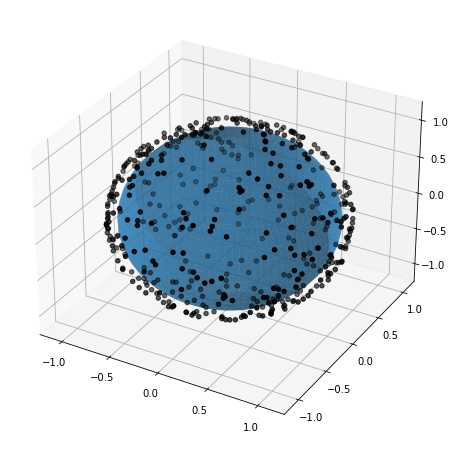

Iter  5
  Time orientations sampling = 2.965893030166626
  cg iter 0 ||r|| = 0.5840440846624065
  cg iter 50 ||r|| = 0.0011952127510880533
  Time cg = 13.067476034164429
Iter  6
  Time orientations sampling = 2.545074939727783
  cg iter 0 ||r|| = 0.5680151890247467
  cg iter 50 ||r|| = 0.0018320706468287974
  Time cg = 7.327073574066162
Iter  7
  Time orientations sampling = 2.2489209175109863
  cg iter 0 ||r|| = 0.5648366746483908
  cg iter 50 ||r|| = 0.0017743033707846882
  Time cg = 7.359001398086548
Iter  8
  Time orientations sampling = 2.271303176879883
  cg iter 0 ||r|| = 0.5695570130896125
  cg iter 50 ||r|| = 0.0015643376212342562
  Time cg = 7.213071823120117


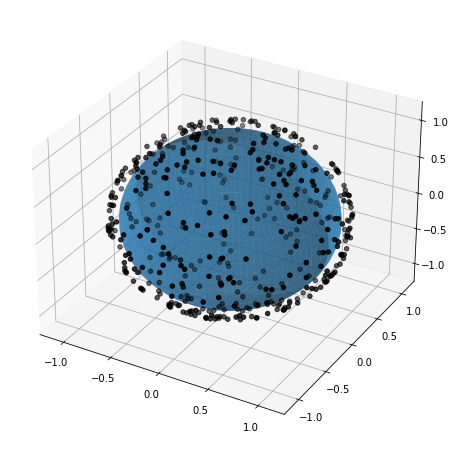

Iter  9
  Time orientations sampling = 3.041719913482666
  cg iter 0 ||r|| = 0.5260988563987118
  cg iter 50 ||r|| = 0.0019283772430643321
  Time cg = 11.74792742729187
Iter  10
  Time orientations sampling = 2.185519218444824
  cg iter 0 ||r|| = 0.5403588875636223
  cg iter 50 ||r|| = 0.0024619284923573107
  Time cg = 8.554100275039673
Iter  11
  Time orientations sampling = 2.2536799907684326
  cg iter 0 ||r|| = 0.5419462779811557
  cg iter 50 ||r|| = 0.0020575357985182043
  Time cg = 7.993863821029663
Iter  12
  Time orientations sampling = 2.117879867553711
  cg iter 0 ||r|| = 0.5572329886880514
  cg iter 50 ||r|| = 0.001885264838186325
  Time cg = 7.8823466300964355


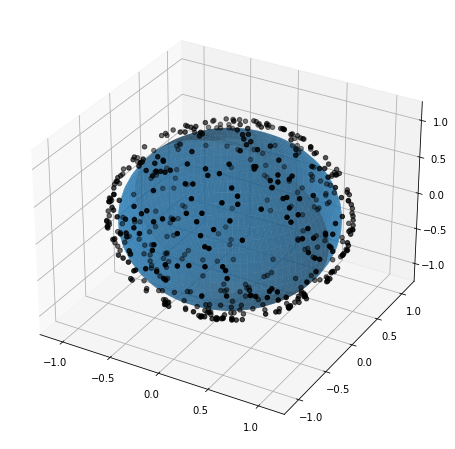

Iter  13
  Time orientations sampling = 3.035306930541992
  cg iter 0 ||r|| = 0.5294643712276569
  cg iter 50 ||r|| = 0.0020036002496268543
  Time cg = 16.110825061798096
Iter  14
  Time orientations sampling = 2.269216537475586
  cg iter 0 ||r|| = 0.5424469256779796
  cg iter 50 ||r|| = 0.002690962245798938
  Time cg = 11.103775978088379
Iter  15
  Time orientations sampling = 2.7521097660064697
  cg iter 0 ||r|| = 0.5333042389655982
  cg iter 50 ||r|| = 0.0021269236247259764
  Time cg = 11.246182441711426
Iter  16
  Time orientations sampling = 2.5381157398223877
  cg iter 0 ||r|| = 0.5276529110494951
  cg iter 50 ||r|| = 0.0022710738072364844
  Time cg = 11.301338911056519


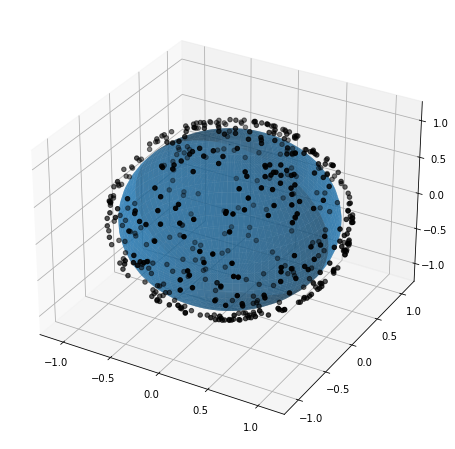

Iter  17
  Time orientations sampling = 3.038508892059326
  cg iter 0 ||r|| = 0.3872554208853322
  cg iter 50 ||r|| = 0.002192494097345339
  Time cg = 20.29905414581299
Iter  18
  Time orientations sampling = 2.466938018798828
  cg iter 0 ||r|| = 0.38853797936505724
  cg iter 50 ||r|| = 0.00233747978161683
  Time cg = 14.501190185546875
Iter  19
  Time orientations sampling = 2.6363039016723633
  cg iter 0 ||r|| = 0.3899028083604035
  cg iter 50 ||r|| = 0.002162574866417266
  Time cg = 14.929008960723877
Iter  20
  Time orientations sampling = 2.7194457054138184
  cg iter 0 ||r|| = 0.3956125394997722
  cg iter 50 ||r|| = 0.002542086504288948
  Time cg = 15.21655535697937


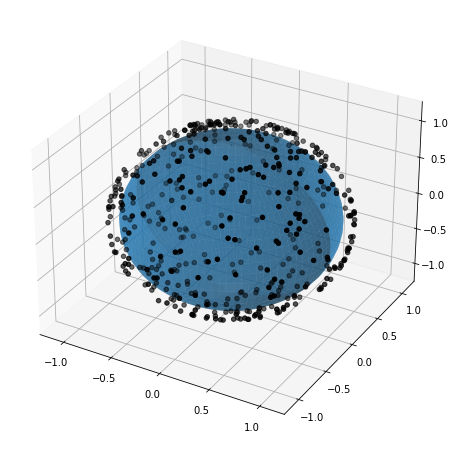

Iter  21
  Time orientations sampling = 3.3817710876464844
  cg iter 0 ||r|| = 0.3536686321073826
  cg iter 50 ||r|| = 0.0024598522616308093
  Time cg = 23.639179229736328
Iter  22
  Time orientations sampling = 2.443790912628174
  cg iter 0 ||r|| = 0.3686605721063818
  cg iter 50 ||r|| = 0.0028052661407033767
  Time cg = 18.229079008102417
Iter  23
  Time orientations sampling = 3.4576809406280518
  cg iter 0 ||r|| = 0.3809473286145769
  cg iter 50 ||r|| = 0.002842595085569442
  Time cg = 18.715530395507812
Iter  24
  Time orientations sampling = 2.4066171646118164
  cg iter 0 ||r|| = 0.39572804122100697
  cg iter 50 ||r|| = 0.0022571820875533755
  Time cg = 18.744754314422607


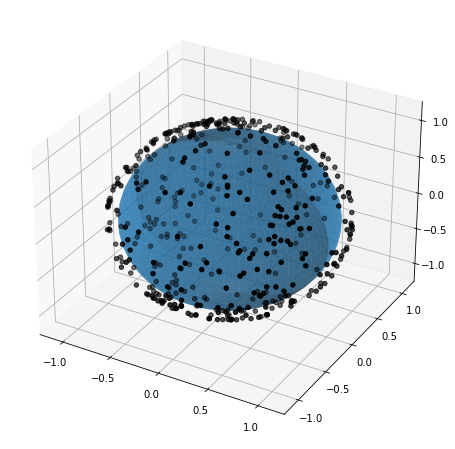

Iter  25
  Time orientations sampling = 3.222041606903076
  cg iter 0 ||r|| = 0.3224136826496411
  cg iter 50 ||r|| = 0.0023395861531825156
  Time cg = 29.43073534965515
Iter  26
  Time orientations sampling = 2.360954761505127
  cg iter 0 ||r|| = 0.32805650662683794
  cg iter 50 ||r|| = 0.002289643053648473
  Time cg = 22.971362590789795
Iter  27
  Time orientations sampling = 2.432432174682617
  cg iter 0 ||r|| = 0.31811658126551573
  cg iter 50 ||r|| = 0.0019583595141483634
  Time cg = 24.056660175323486
Iter  28
  Time orientations sampling = 2.6306018829345703
  cg iter 0 ||r|| = 0.3071336173034167
  cg iter 50 ||r|| = 0.001885520822302395
  Time cg = 23.80694580078125


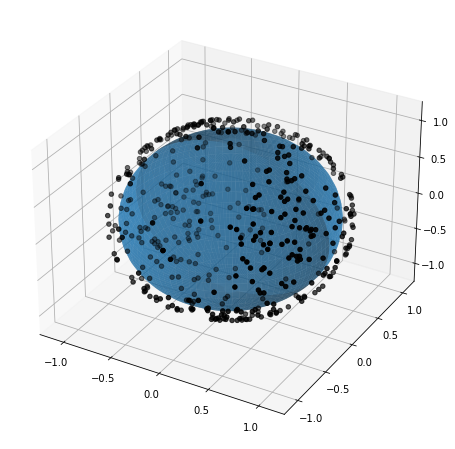

Iter  29
  Time orientations sampling = 3.335515022277832
  cg iter 0 ||r|| = 0.2620280661739327
  cg iter 50 ||r|| = 0.0017752256841177974
  Time cg = 23.61799955368042


In [19]:
N_samples = 40000
N_iter = 100
N_cg_iter = 100
dr = 0.005
radius = 0.01
alpha = 0

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])
vcg = ab_initio(project, imgs_f, shifts, ctf_params, x_grid, N_iter, N_cg_iter, N_samples, radius, dr, alpha, 'tri', True, True, True, out_dir)

### CG

In [20]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 20

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape)

In [21]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.05097052279774336


In [22]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [ ]:
i = 110
s0 = slice_func(vcg1, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

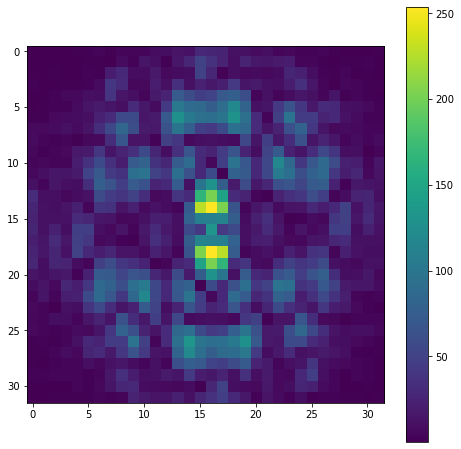

In [24]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

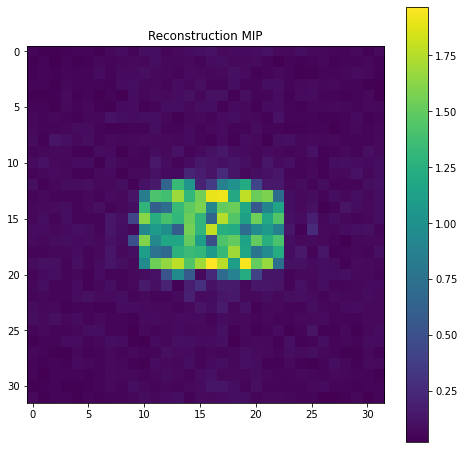

In [25]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [26]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

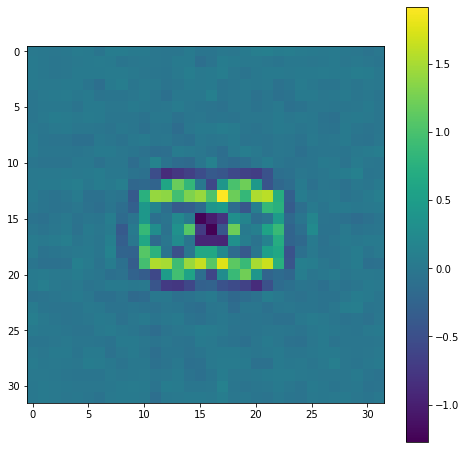

In [27]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

### Write volume to file

In [28]:
with mrcfile.new('../data/reconstruction_data_32.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


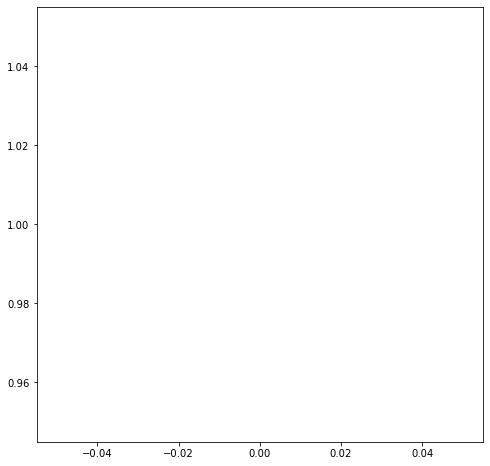

In [31]:
plt.plot(res,fsc)

In [32]:
points_v_tri = points_orientations_tri(angles[:50], x_grid[1])

KeyboardInterrupt: 

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()